In [2]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications import vgg19

base_image_path = keras.utils.get_file('andy.jpg','https://spectrum.ieee.org/image/MjcxODg1NQ.jpeg')
style_reference_image_path = keras.utils.get_file(
    "m_arts.jpg",'https://cdn11.bigcommerce.com/s-x49po/images/stencil/1280x1280/products/36835/50093/1547274864391_Screenshot_20190108_111037_copy__55052.1547528015.jpg?c=2')
result_prefix = "Andrew's"


total_variation_weight = 1e-6
style_weight = 1e-6
content_weight = 2.5e-8

width, height = keras.preprocessing.image.load_img(base_image_path).size
img_nrows = 400
img_ncols = int(width * img_nrows / height)

In [2]:
def preprocess_image(image_path):
    img = keras.preprocessing.image.load_img(
        image_path, target_size=(img_nrows, img_ncols)
    )
    img = keras.preprocessing.image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = vgg19.preprocess_input(img)
    return tf.convert_to_tensor(img)


def deprocess_image(x):
    x = x.reshape((img_nrows, img_ncols, 3))
    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68
    # 'BGR'->'RGB'
    x = x[:, :, ::-1]
    x = np.clip(x, 0, 255).astype("uint8")
    return x

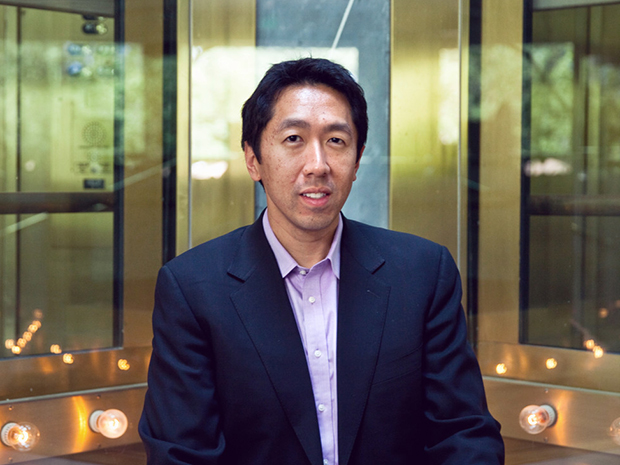

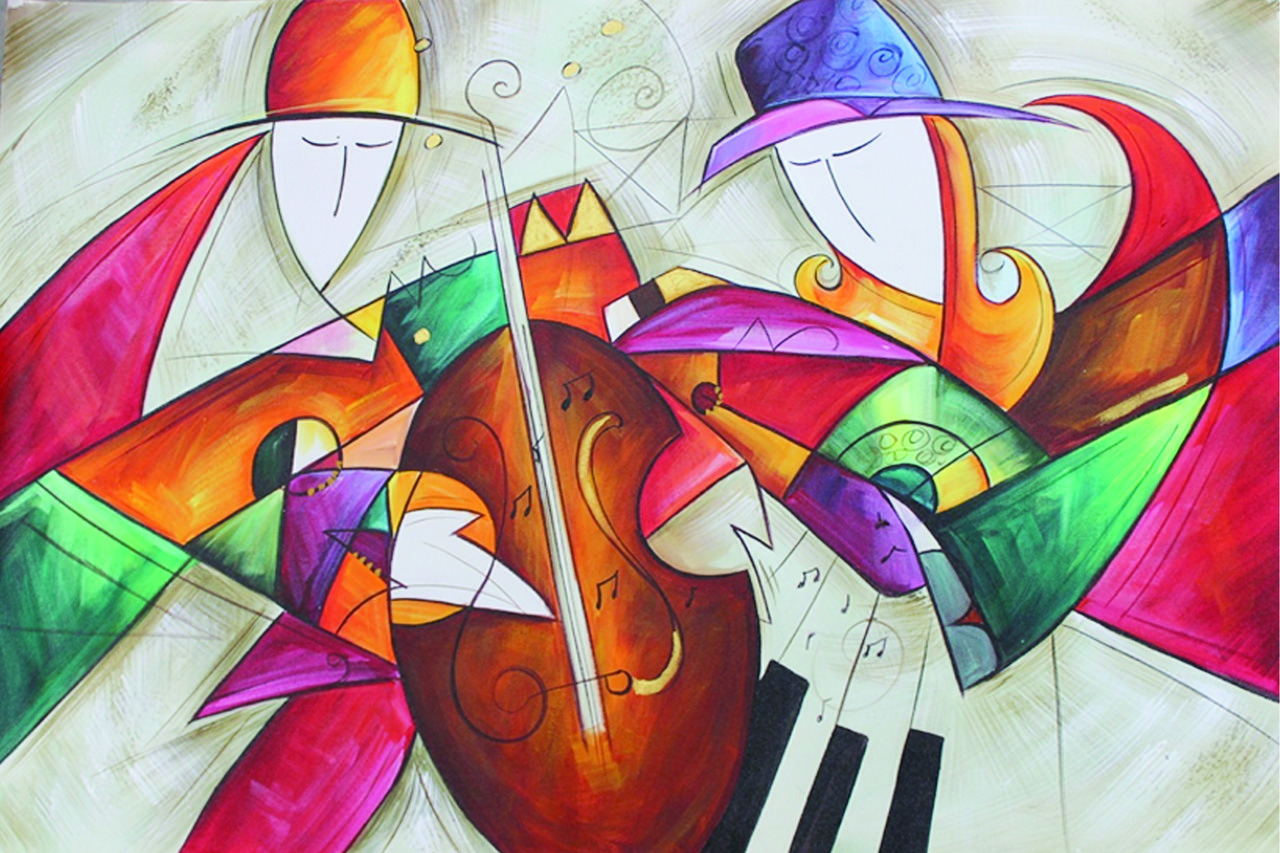

In [4]:
from IPython.display import Image, display

display(Image(base_image_path))
display(Image(style_reference_image_path))

In [4]:
def gram_matrix(x):
    x = tf.transpose(x, (2, 0, 1))
    features = tf.reshape(x, (tf.shape(x)[0], -1))
    gram = tf.matmul(features, tf.transpose(features))
    return gram

In [5]:
def style_loss(style, combination):
    S = gram_matrix(style)
    C = gram_matrix(combination)
    channels = 3
    size = img_nrows * img_ncols
    return tf.reduce_sum(tf.square(S - C)) / (4.0 * (channels ** 2) * (size ** 2))

In [6]:
def content_loss(base, combination):
    return tf.reduce_sum(tf.square(combination - base))


In [7]:
def total_variation_loss(x):
    a = tf.square(
        x[:, : img_nrows - 1, : img_ncols - 1, :] - x[:, 1:, : img_ncols - 1, :]
    )
    b = tf.square(
        x[:, : img_nrows - 1, : img_ncols - 1, :] - x[:, : img_nrows - 1, 1:, :]
    )
    return tf.reduce_sum(tf.pow(a + b, 1.25))

In [8]:
model = vgg19.VGG19(weights="imagenet", include_top=False)

outputs_dict = dict([(layer.name, layer.output) for layer in model.layers])

feature_extractor = keras.Model(inputs=model.inputs, outputs=outputs_dict)

In [9]:
style_layer_names = [
    "block1_conv1",
    "block2_conv1",
    "block3_conv1",
    "block4_conv1",
    "block5_conv1",
]
content_layer_name = "block5_conv2"


def compute_loss(combination_image, base_image, style_reference_image):
    input_tensor = tf.concat(
        [base_image, style_reference_image, combination_image], axis=0
    )
    features = feature_extractor(input_tensor)

    loss = tf.zeros(shape=())

    layer_features = features[content_layer_name]
    base_image_features = layer_features[0, :, :, :]
    combination_features = layer_features[2, :, :, :]
    loss = loss + content_weight * content_loss(
        base_image_features, combination_features
    )
    for layer_name in style_layer_names:
        layer_features = features[layer_name]
        style_reference_features = layer_features[1, :, :, :]
        combination_features = layer_features[2, :, :, :]
        sl = style_loss(style_reference_features, combination_features)
        loss += (style_weight / len(style_layer_names)) * sl

    loss += total_variation_weight * total_variation_loss(combination_image)
    return loss

In [10]:
@tf.function
def compute_loss_and_grads(combination_image, base_image, style_reference_image):
    with tf.GradientTape() as tape:
        loss = compute_loss(combination_image, base_image, style_reference_image)
    grads = tape.gradient(loss, combination_image)
    return loss, grads

In [11]:
optimizer = keras.optimizers.SGD(
    keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=100.0, decay_steps=100, decay_rate=0.96
    )
)

base_image = preprocess_image(base_image_path)
style_reference_image = preprocess_image(style_reference_image_path)
combination_image = tf.Variable(preprocess_image(base_image_path))

iterations = 4000
for i in range(1, iterations + 1):
    loss, grads = compute_loss_and_grads(
        combination_image, base_image, style_reference_image
    )
    optimizer.apply_gradients([(grads, combination_image)])
    if i % 100 == 0:
        print("Iteration %d: loss=%.2f" % (i, loss))
        img = deprocess_image(combination_image.numpy())
        fname = result_prefix + "_iteration_%d.png" % i
        keras.preprocessing.image.save_img(fname, img)

Iteration 100: loss=8458.59
Iteration 200: loss=6674.77
Iteration 300: loss=5928.20
Iteration 400: loss=5490.67
Iteration 500: loss=5191.78
Iteration 600: loss=4976.25
Iteration 700: loss=4813.12
Iteration 800: loss=4684.98
Iteration 900: loss=4577.45
Iteration 1000: loss=4489.27
Iteration 1100: loss=4413.58
Iteration 1200: loss=4345.53
Iteration 1300: loss=4284.13
Iteration 1400: loss=4228.74
Iteration 1500: loss=4179.94
Iteration 1600: loss=4134.94
Iteration 1700: loss=4093.65
Iteration 1800: loss=4056.04
Iteration 1900: loss=4021.52
Iteration 2000: loss=3991.04
Iteration 2100: loss=3963.32
Iteration 2200: loss=3936.89
Iteration 2300: loss=3912.79
Iteration 2400: loss=3891.16
Iteration 2500: loss=3871.60
Iteration 2600: loss=3852.58
Iteration 2700: loss=3834.81
Iteration 2800: loss=3818.88
Iteration 2900: loss=3804.27
Iteration 3000: loss=3790.64
Iteration 3100: loss=3778.28
Iteration 3200: loss=3767.12
Iteration 3300: loss=3756.42
Iteration 3400: loss=3746.67
Iteration 3500: loss=37

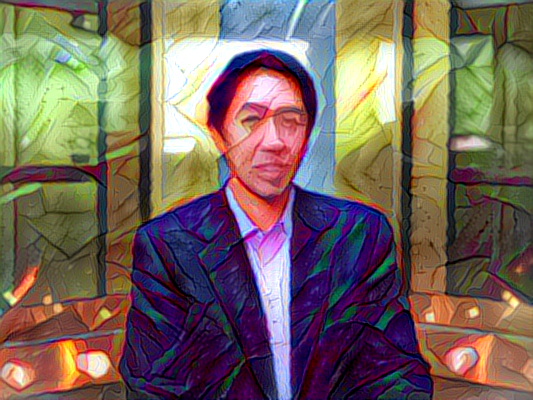

In [6]:
display(Image(result_prefix + "_iteration_4000.png"))